In [1]:
"""
Created on Sat Aug 11 21:16:42 2019

@author: Paras
"""

import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from collections import Counter
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from keras.utils import to_categorical

Using TensorFlow backend.
/home/shreyas_n1799/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shreyas_n1799/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shreyas_n1799/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/shreyas_n1799/venv/lib/python3.6/site-packag

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))    
    return df

def import_data(file, encoding='utf-8'):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True, encoding=encoding)
    df = reduce_mem_usage(df)
    return df

def to_IOB(tag):
    if 'U-' in tag:
        tag = tag.replace('U-', 'B-')
    elif 'L-' in tag:
        tag = tag.replace('L-', 'I-')
    
    return tag

def format_tags(tag):
    entities = ['CARDINAL','TIME','DATE','ORDINAL','ORG','MONEY','PERCENT','LANGUAGE','LAW','QUANTITY']
    tag = 'O' if any(entity in tag for entity in entities) else tag
    return tag
    
def map_fire_tags(tag):
    entities = ['PERSON','GPE','-LOC','-FAC','ORG','WORK_OF_ART','EVENT','NORP','PRODUCT']
    tag = tag if any(entity in tag for entity in entities) else 'O'
    tag = 'O' if 'LOCO' in tag else tag
    return tag
    
def preprocess_fire(fire_df):
    fire_df = fire_df.iloc[28:, [0,1,4]]
    fire_df.columns = ['Sentence #', 'Word', 'Tag']
    fire_df.reset_index(inplace=True, drop=True)
    
    # Assign sentence boundaries
    prev = 1
    for i in range(len(fire_df)):
        if type(fire_df.at[i, 'Word']) == str and fire_df.at[i, 'Word'] == '*':
            prev+=1
        elif type(fire_df.at[i, 'Word']) == float and math.isnan(fire_df.at[i, 'Word']):
            prev += 1
        fire_df.at[i, 'Sentence #'] = prev
        
    # removal of excess tags
    fire_df['Tag'] = fire_df['Tag'].apply(lambda tag: map_fire_tags(format_tags(tag)))
    fire_df = fire_df.dropna()
    return fire_df

In [3]:
dataset = import_data('../../../Data/ner-data/ontonotes_raw.csv')

/home/shreyas_n1799/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Memory usage of dataframe is 259.55 MB
Memory usage after optimization is: 52.97 MB
Decreased by 79.6%


In [4]:
df = dataset.iloc[:, [4,5,6,13]]
df.columns = ['Sentence #','Word','POS','Tag']
df['Sentence #'] = df['Sentence #'].astype('int64')

/home/shreyas_n1799/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
df.head()

,Sentence #,Word,POS,Tag
0,0,Like,IN,O
1,1,many,JJ,O
2,2,Heartland,NNP,U-LOC
3,3,states,NNS,O
4,4,",",",",O


In [6]:
print(df.isna().sum())
print(df['Sentence #'].unique())

Sentence #     0
Word          10
POS            0
Tag            0
dtype: int64
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209]


In [7]:
df.dtypes

Sentence #       int64
Word          category
POS           category
Tag           category
dtype: object

In [8]:
df['Sentence #'].value_counts()

0      43335
1      42010
2      38969
3      37555
4      36056
       ...  
206        1
207        1
208        1
205        1
209        1
Name: Sentence #, Length: 210, dtype: int64

In [9]:
df.dropna(inplace=True)
df = df.reset_index(drop=True)

for col in df.columns[1:]:
    df[col] = df[col].astype('object')
    
df.head()

/home/shreyas_n1799/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Sentence #,Word,POS,Tag
0,0,Like,IN,O
1,1,many,JJ,O
2,2,Heartland,NNP,U-LOC
3,3,states,NNS,O
4,4,",",",",O


In [10]:
df['Tag'].unique()

array(['O', 'U-LOC', 'U-GPE', 'U-ORG', 'B-PERSON', 'L-PERSON', 'B-TIME',
       'L-TIME', 'B-GPE', 'I-GPE', 'L-GPE', 'U-CARDINAL', 'B-LOC',
       'L-LOC', 'U-NORP', 'B-NORP', 'L-NORP', 'B-DATE', 'I-DATE',
       'L-DATE', 'U-ORDINAL', 'I-PERSON', 'B-QUANTITY', 'L-QUANTITY',
       'B-ORG', 'L-ORG', 'U-DATE', 'B-MONEY', 'I-MONEY', 'L-MONEY',
       'U-MONEY', 'U-PERSON', 'U-TIME', 'B-CARDINAL', 'I-CARDINAL',
       'L-CARDINAL', 'I-ORG', 'U-FAC', 'I-LOC', 'U-PRODUCT', 'B-EVENT',
       'L-EVENT', 'B-PRODUCT', 'I-PRODUCT', 'L-PRODUCT', 'B-FAC', 'I-FAC',
       'L-FAC', 'I-QUANTITY', 'B-PERCENT', 'L-PERCENT', 'B-WORK_OF_ART',
       'I-WORK_OF_ART', 'L-WORK_OF_ART', 'I-TIME', 'I-EVENT', 'I-PERCENT',
       'U-WORK_OF_ART', 'U-QUANTITY', 'I-NORP', 'B-LAW', 'I-LAW', 'L-LAW',
       'U-LAW', 'U-LANGUAGE', 'B-ORDINAL', 'L-ORDINAL', 'U-EVENT',
       'B-LANGUAGE', 'I-LANGUAGE', 'L-LANGUAGE', 'I-ORDINAL', 'U-PERCENT'],
      dtype=object)

In [11]:
entities = ['CARDINAL','TIME','DATE','ORDINAL','MONEY','PERCENT','LANGUAGE','LAW','QUANTITY']
df['Tag'] = df['Tag'].apply(lambda tag: to_IOB(tag))
df['Tag'] = df['Tag'].apply(lambda tag: 'O' if any(entity in tag for entity in entities) else tag)
df.head()

,Sentence #,Word,POS,Tag
0,0,Like,IN,O
1,1,many,JJ,O
2,2,Heartland,NNP,B-LOC
3,3,states,NNS,O
4,4,",",",",O


In [12]:
prev = 1
for i in range(len(df)-1):
    if df.at[i, 'Sentence #'] > df.at[i+1, 'Sentence #']:
        df.at[i, 'Sentence #'] = prev
        prev += 1
    else:
        df.at[i, 'Sentence #'] = prev

df.at[len(df)-1, 'Sentence #'] = prev

In [13]:
print('Number of sentences in OntoNotes dataset:', df['Sentence #'].nunique())

Number of sentences in OntoNotes dataset: 42010


In [14]:
df['Sentence #'].unique()

array([    1,     2,     3, ..., 42008, 42009, 42010])

In [15]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(), 
                                                           s['POS'].values.tolist(), 
                                                           s['Tag'].values.tolist())]
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try: 
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent += 1
            return s 
        except:
            return None

In [16]:
getter = SentenceGetter(df)
sentences = getter.sentences

In [17]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0, 
        'word.lower()': word.lower(), 
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [18]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=0)

In [20]:
print('X_train shape:', len(X_train))
print('X_test shape:', len(X_test))

X_train shape: 33608
X_test shape: 8402


In [31]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [32]:
test_pred = crf.predict(X_test)

In [33]:
np.unique(df['Tag'])

array(['B-EVENT', 'B-FAC', 'B-GPE', 'B-LOC', 'B-NORP', 'B-ORG',
       'B-PERSON', 'B-PRODUCT', 'B-WORK_OF_ART', 'I-EVENT', 'I-FAC',
       'I-GPE', 'I-LOC', 'I-NORP', 'I-ORG', 'I-PERSON', 'I-PRODUCT',
       'I-WORK_OF_ART', 'O'], dtype=object)

In [34]:
classes = np.unique(df['Tag'])
classes = classes.tolist()
new_classes = classes.copy()
new_classes.pop()
new_classes

['B-EVENT',
 'B-FAC',
 'B-GPE',
 'B-LOC',
 'B-NORP',
 'B-ORG',
 'B-PERSON',
 'B-PRODUCT',
 'B-WORK_OF_ART',
 'I-EVENT',
 'I-FAC',
 'I-GPE',
 'I-LOC',
 'I-NORP',
 'I-ORG',
 'I-PERSON',
 'I-PRODUCT',
 'I-WORK_OF_ART']

In [35]:
print(metrics.flat_classification_report(y_test, test_pred, labels = new_classes))

               precision    recall  f1-score   support

      B-EVENT       0.81      0.65      0.72       115
        B-FAC       0.75      0.63      0.68       103
        B-GPE       0.94      0.94      0.94      2200
        B-LOC       0.74      0.66      0.70       183
       B-NORP       0.95      0.94      0.95      1008
        B-ORG       0.86      0.84      0.85      1343
     B-PERSON       0.94      0.94      0.94      2100
    B-PRODUCT       1.00      0.70      0.83        91
B-WORK_OF_ART       0.76      0.50      0.60       156
      I-EVENT       0.80      0.66      0.73       286
        I-FAC       0.79      0.67      0.73       209
        I-GPE       0.88      0.81      0.85       545
        I-LOC       0.76      0.71      0.73       182
       I-NORP       0.80      0.73      0.77        49
        I-ORG       0.84      0.90      0.87      2014
     I-PERSON       0.94      0.95      0.95      1552
    I-PRODUCT       1.00      0.76      0.86        70
I-WORK_OF

### View transitions learned

In [36]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))
        
print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(5))
print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-5:])

Top likely transitions:
I-ORG  -> I-ORG   7.855250
I-LOC  -> I-LOC   7.081256
I-EVENT -> I-EVENT 6.981851
B-FAC  -> I-FAC   6.609131
I-GPE  -> I-GPE   6.589637
I-PERSON -> I-PERSON 6.583714
I-FAC  -> I-FAC   6.316319
I-WORK_OF_ART -> I-WORK_OF_ART 6.245776
I-PRODUCT -> I-PRODUCT 6.115015
B-ORG  -> I-ORG   6.109783
B-EVENT -> I-EVENT 6.019308
B-WORK_OF_ART -> I-WORK_OF_ART 5.962847
B-LOC  -> I-LOC   5.759106
B-PERSON -> I-PERSON 5.513699
B-GPE  -> I-GPE   5.504240
I-NORP -> I-NORP  5.344617
B-NORP -> I-NORP  5.162655
B-PRODUCT -> I-PRODUCT 4.693067
O      -> O       3.123972
O      -> B-PERSON 2.136964

Top unlikely transitions:
B-GPE  -> I-EVENT -2.331352
I-GPE  -> I-ORG   -2.334991
B-LOC  -> I-GPE   -2.366032
B-GPE  -> I-FAC   -2.378598
B-NORP -> I-WORK_OF_ART -2.633588
B-NORP -> I-EVENT -2.671352
B-GPE  -> I-PERSON -2.707355
B-LOC  -> B-GPE   -2.837064
B-ORG  -> I-PERSON -2.864605
B-GPE  -> I-ORG   -3.343841
B-NORP -> I-ORG   -4.887052
O      -> I-WORK_OF_ART -5.439544
O      -> I-PR

### View state features

In [37]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))
print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))
print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
6.433712 O        +1:word.lower():dollars
5.603067 B-NORP   word.lower():democrat
5.498427 B-PERSON word.lower():mccain
5.462755 O        BOS
5.458743 O        word.lower():president
5.141337 B-LOC    word.lower():balkans
5.128955 O        word.lower():secretary
5.083859 B-LOC    word.lower():asia
5.057007 B-PERSON word.lower():kramers
5.049974 B-PERSON word.lower():gore
5.022779 O        bias
4.815821 B-WORK_OF_ART word.lower():newsnight
4.794678 B-GPE    word.lower():france
4.771878 B-ORG    word.lower():kuomintang
4.768246 I-GPE    -1:word.lower():west
4.764711 B-PERSON word.lower():hsia
4.760342 B-GPE    word.lower():belgrade
4.661371 B-EVENT  word.lower():watergate
4.653345 O        word.lower():minister
4.629560 B-ORG    word.lower():hamas
4.622076 O        +1:word.lower():charter
4.614344 B-GPE    word.lower():japan
4.577945 B-WORK_OF_ART word.lower():hardball
4.574222 O        word.lower():chairman
4.569844 O        word.lower():english
4.553216 O        word.lowe

In [48]:
import eli5
eli5.show_weights(crf, top=10)

Using TensorFlow backend.
/home/shreyas_n1799/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shreyas_n1799/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shreyas_n1799/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/shreyas_n1799/venv/lib/python3.6/site-packag

From \ To,O,B-EVENT,I-EVENT,B-FAC,I-FAC,B-GPE,I-GPE,B-LOC,I-LOC,B-NORP,I-NORP,B-ORG,I-ORG,B-PERSON,I-PERSON,B-PRODUCT,I-PRODUCT,B-WORK_OF_ART,I-WORK_OF_ART
O,3.124,0.248,-5.958,0.111,-5.641,1.464,-7.263,0.331,-6.302,0.894,-5.601,0.841,-7.537,2.137,-6.179,0.555,-5.537,0.677,-5.44
B-EVENT,-1.51,-0.267,6.019,0.0,-0.726,-0.786,-1.425,-0.005,-0.658,-1.027,-0.187,-1.426,-1.517,-0.867,-1.361,0.0,-0.57,-0.188,-0.49
I-EVENT,-0.875,0.179,6.982,0.0,-0.183,-1.341,-0.129,-0.008,0.0,-0.411,0.0,-0.175,-0.822,-1.114,-0.765,0.0,-0.005,-0.247,-0.688
B-FAC,-0.675,0.0,-0.523,-0.01,6.609,-0.558,-1.33,0.0,-0.551,-0.286,0.0,-0.839,-1.32,-0.931,-1.0,0.0,-0.431,0.0,-0.362
I-FAC,-0.91,-0.298,-0.637,-0.703,6.316,-0.161,-0.891,-0.393,-0.602,-0.152,0.0,-1.828,-1.159,-1.806,-1.142,-0.071,-0.312,-0.117,-0.612
B-GPE,0.882,-0.151,-2.331,-0.27,-2.379,1.518,5.504,0.265,-1.913,-0.175,-2.086,-0.148,-3.344,-0.567,-2.707,-0.372,-1.562,-0.393,-1.841
I-GPE,-1.086,-0.79,-1.126,-0.341,-1.35,0.356,6.59,-0.082,-1.146,-0.213,-0.244,-0.513,-2.335,-0.26,-1.282,-0.142,-0.502,-0.652,-1.161
B-LOC,0.206,-0.514,-0.908,-0.177,-1.014,-2.837,-2.366,-1.668,5.759,-1.259,-0.481,-1.296,-1.561,-0.731,-1.379,0.0,-1.119,0.0,-0.798
I-LOC,-0.635,-0.014,-0.683,-0.069,-0.464,-0.591,-0.857,-0.333,7.081,-0.416,0.0,-0.959,-1.126,-0.803,-0.726,0.0,0.0,0.0,-0.325
B-NORP,0.564,-0.972,-2.671,-0.878,-1.293,-0.501,-1.724,-0.736,-1.87,-0.922,5.163,-0.869,-4.887,0.669,-2.25,-0.456,-1.083,-1.111,-2.634


In [50]:
eli5.show_weights(crf, top=10, targets=['O', 'B-ORG', 'I-PERSON'])

# LSTM-CRF

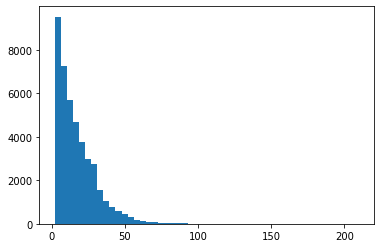

In [61]:
plt.hist([len(sen) for sen in getter.sentences], bins=50)
plt.show()

In [62]:
words = list(set(df['Word'].values))
words.append('ENDPAD')
n_words = len(words); n_words

27533

In [63]:
tags = list(set(df['Tag'].values))
n_tags = len(tags); n_tags

19

In [64]:
max_len = 50
word2idx = {w: i+1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [65]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)

In [66]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

y = [to_categorical(i, num_classes=n_tags) for i in y]

In [67]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

In [68]:
len(y_tr)

33608

In [78]:
input_text = Input(shape=(max_len,))
model = Embedding(input_dim=n_words+1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input_text)
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(50, activation='relu'))(model)
crf = CRF(n_tags)
out = crf(model)
# out = model

TypeError: Tensors in list passed to 'values' of 'ConcatV2' Op have types [bool, float32] that don't all match.

In [ ]:
model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()

In [ ]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5,
                    validation_split=0.1, verbose=1)

In [ ]:
hist = pd.DataFrame(history.history)
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [ ]:
test_pred = model.predict(X_te, verbose=1)

In [ ]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
print(classification_report(test_labels, pred_labels))

In [ ]:
i = 2019
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))